In [1]:
# Simple WP, V field solver and signal generation
# Ren Cooper, LBNL & Joanna Szornel, UC Berkeley and LBNL
# Gamma-Ray Tracking School, ORNL, October 2018

In [2]:
%matplotlib inline
%reset -f

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

In [139]:
def import_drift_velocities(plot=False):
    # import drift velocities
    filename = './drift_velocities.txt'
    drift_velocity_table = np.genfromtxt(filename, comments='#', delimiter=None)
    
    E_vals = drift_velocity_table[:,0]
    e_vals = drift_velocity_table[:,1]
    h_vals = drift_velocity_table[:,4]
    x = np.linspace(0, 5000, 20)  # V/cm
    e_func = interp1d(E_vals, e_vals, kind='cubic')
    h_func = interp1d(E_vals, h_vals, kind='cubic')
    
    if plot == True:
        plt.plot(x,e_func(x),'--' )
        plt.plot(x,h_func(x),'--' )
        plt.plot()
        plt.ylabel('v (mm/ns)')
        plt.xlabel('E (V/cm)')
        plt.show()
    
    return x, e_func, h_func

x, efunc, hfunc = import_drift_velocities()

In [7]:
# set some detector parameters (mm)
strip_width_mm = 2.8
strip_gap_mm = 0.2
pixel_size_mm = 0.1

# set detector width to n*pitch where n is an odd number
#detector_width_mm = (3*strip_width_mm+strip_gap_mm)
#detector_width_mm = strip_width_mm  * 3
detector_width_mm = 10.0
detector_thickness_mm = 10.0 #16.0

outer_contact_bias = 1000.0
core_contact_bias = 0.0

charge_density_zero = -1.0
charge_density_gradient = 0.1

In [8]:
# build some grids
x_range = np.arange(-detector_width_mm/2 + pixel_size_mm, detector_width_mm/2 + pixel_size_mm, pixel_size_mm)
y_range = np.arange(-pixel_size_mm, detector_thickness_mm + pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)
W = np.zeros((N_xelements, N_yelements), dtype=float)
E = np.zeros((N_xelements, N_yelements), dtype=float)

In [140]:
def V_geom_map(Nx, Ny):
    # Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
    geom_map = np.zeros((Nx, Ny), dtype=int)
    
    geom_map[0,:] = 4
    geom_map[-1,:] = 4
    geom_map[:,0] = 3
    geom_map[:,-1] = 1
    return geom_map

In [141]:
V_geom_map(N_xelements, N_yelements)
print(geom_map)

[[3 4 4 ..., 4 4 1]
 [3 0 0 ..., 0 0 1]
 [3 0 0 ..., 0 0 1]
 ..., 
 [3 0 0 ..., 0 0 1]
 [3 0 0 ..., 0 0 1]
 [3 4 4 ..., 4 4 1]]


[[3 4 4 ..., 4 4 1]
 [3 0 0 ..., 0 0 1]
 [3 0 0 ..., 0 0 1]
 ..., 
 [3 0 0 ..., 0 0 1]
 [3 0 0 ..., 0 0 1]
 [3 4 4 ..., 4 4 1]]
[[-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]
 [-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]
 [-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]
 ..., 
 [-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]
 [-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]
 [-1.    -0.999 -0.998 ..., -0.901 -0.9   -0.899]]
[[    0.             9.80392157    19.60784314 ...,   970.58823529
    980.39215686  1000.        ]
 [    0.             9.80392157    19.60784314 ...,   970.58823529
    980.39215686  1000.        ]
 [    0.             9.80392157    19.60784314 ...,   970.58823529
    980.39215686  1000.        ]
 ..., 
 [    0.             9.80392157    19.60784314 ...,   970.58823529
    980.39215686  1000.        ]
 [    0.             9.80392157    19.60784314 ...,   970.58823529
    980.39215686  1000.        ]
 [    0.             9.80392157    19.60784314 ...,   970

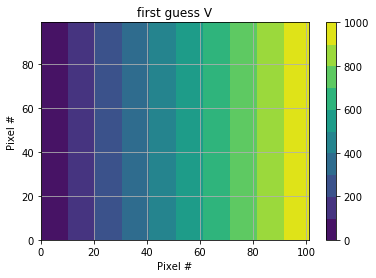

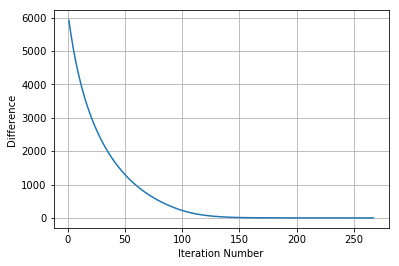

Final Difference:
0.00951580966833


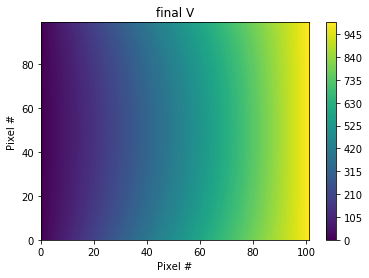

In [18]:

V = np.zeros((N_xelements, N_yelements), dtype=float)

#####

# set up charge distribution through xtal
charge = np.zeros((N_xelements, N_yelements), dtype=float)
pixels_to_cm = 10/pixel_size_mm

for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        charge[x,y] = float(charge_density_zero + charge_density_gradient*(y/pixels_to_cm))

print(geom_map)
print(charge)


#####

# set boundary conditions and generate initial guess at solution

# initial guess at solution
for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        V[x,y] = outer_contact_bias*y / N_yelements

# outer contact
x,y = np.where(geom_map==1)
V[x,y] = outer_contact_bias

# core
x,y = np.where(geom_map==3)
V[x,y] = core_contact_bias

# passivated back face (not tested)
#x,y = np.where(geom_map==3)
#V[x,y] = 0.0

print(V)
plt.contourf(V,10,interpolation="None")
plt.grid("on")
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()
plt.title('first guess V')
plt.show()

# do the relaxation to solve

# set maximum number of iterations
max_iters = 1000

# calculate term for Coulombs per pixel / Epsilon
#e_over_e = (pixel_size_mm*pixel_size_mm) * 1e10 * 1.6e-19
e_over_e = (pixel_size_mm*pixel_size_mm/4)* (1e10*1.6e-19)/(16*8.85e-12)

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01
while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for x in range(1, N_xelements - 1):
        for y in range(1, N_yelements - 1):
                        
            # skip non-Ge pixels
            if (geom_map[x,y] != 0):
                continue
                
            # deal with reflection symmetry at x=0
            #if (x == 0):
            #    V_local_sum = (V[x,y-1] + V[x,y+1] + 2.0*V[x+1,y])
            #
            #elif (y == 0):
            #    V_local_sum = (V[x-1,y] + V[x+1,y] + 2.0*V[x,y+1])

            # all other cases
            #else:                                
            #    V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            
            # update the solution
            R[x,y] = (0.25*V_local_sum + (charge[x,y] * e_over_e)) - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]
                 
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
#plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])
plt.contourf(V, 200, vmin=0)
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()
plt.title('final V')
plt.show()

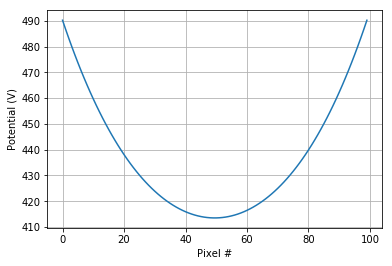

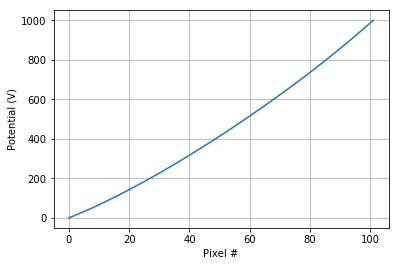

In [19]:
# plot some potential/field slices
yy = int(N_yelements / 2)
xx = int(N_xelements / 2)

# V along the radial direction at rad = xx
plt.plot(V[:,int(xx)])
plt.grid("on")
plt.xlabel("Pixel #")
plt.ylabel("Potential (V)")
plt.show()

# V along the longitudinal direction at long =yy
plt.plot(V[int(yy)])
plt.grid("on")
plt.xlabel("Pixel #")
plt.ylabel("Potential (V)")
plt.show()

Vslice = V[int(yy)]

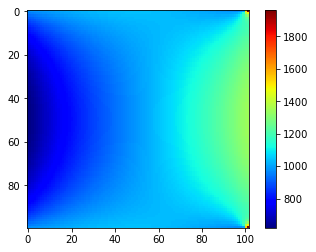

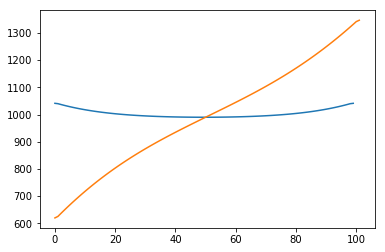

In [24]:
###### calculate the electric field from the potential
#  - this doesn't deal with boundaries properly!
[Ex, Ey] = np.gradient(-V)
Ex = Ex * pixels_to_cm
Ey = Ey * pixels_to_cm
E = np.sqrt((Ex*Ex) + (Ey*Ey))


#Efinal = np.flipud(E)
#Efinal = np.append(Efinal, E, axis=0)

Efinal = E

plt.imshow(Efinal[:,:], interpolation="None", cmap="jet")
plt.colorbar()
plt.show()
plt.plot( Efinal[:,int(xx)])
plt.plot( Efinal[yy])
plt.show()
#Eslice = Efinal[yy]
#plt.plot(Eslice,'o')
#plt.show()
Eslice = Efinal[yy]

In [28]:
# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# continous contact
geom_map[:,0] = 3

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,0] = 3

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,0] = 3

# strip surface
geom_map[:,-1] = 2

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,-1] = 2

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,-1] = 2

# strip 
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,-1] = 1

# gap
ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4

ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4

geom_map = np.zeros((N_xelements, N_yelements), dtype=int)
geom_map[0,:] = 4
geom_map[-1,:] = 4
geom_map[:,0] = 3
geom_map[:,-1] = 1

In [29]:

# set boundary conditions 

# non-strip contacts
[ix,iy] = np.where(geom_map == 2)
W[ix,iy] = 0
#V[ix,iy] = 0

# back face
[ix,iy] = np.where(geom_map == 3)
W[ix,iy] = 0
#V[ix,iy] = 1000

# strip
[ix,iy] = np.where(geom_map == 1)
W[ix,iy] = 1
#V[ix,iy] = 0

In [30]:
print(geom_map)

[[3 4 4 ..., 4 4 1]
 [3 0 0 ..., 0 0 1]
 [3 0 0 ..., 0 0 1]
 ..., 
 [3 0 0 ..., 0 0 1]
 [3 0 0 ..., 0 0 1]
 [3 4 4 ..., 4 4 1]]


In [31]:
# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):
                        
            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue
                
            # should deal with some boundary conditions...
                                   
            W_local_sum = (W[x+1,y] + W[x,y+1] + W[x-1,y] + W[x,y-1])
            
            # update the solution
            R[x,y] = 0.25*W_local_sum - W[x,y]
            W[x,y] = W[x,y] + w*R[x,y]
            
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1

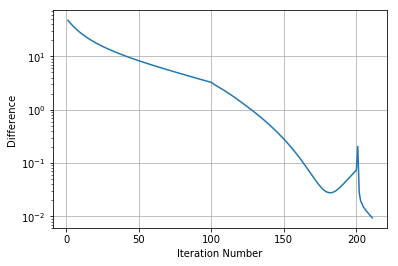

Final Difference:
0.00936260456928


In [32]:
# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

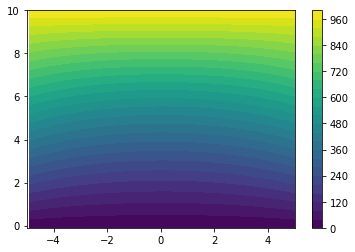

In [33]:
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, V, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()

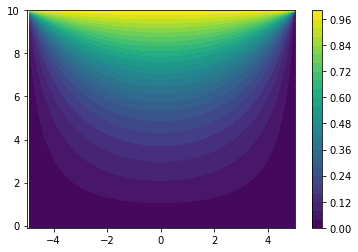

In [34]:
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, W, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()

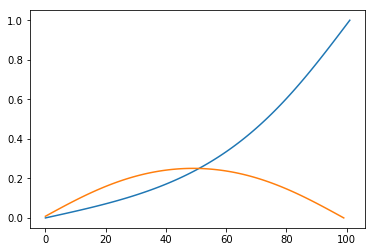

In [37]:
plt.plot(W[int(xx),:])
plt.plot(W[:,int(yy)])
plt.show()

In [35]:
y = np.linspace(0, N_yelements,N_yelements)

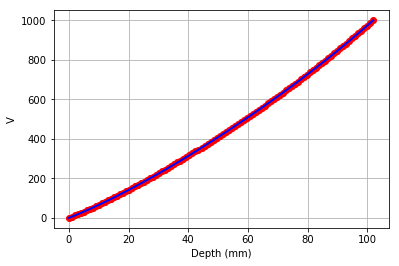

In [36]:
# take a slice through the V

Vslice = V[int(yy)]
Vfunc = interp1d(y, Vslice, kind='cubic')

plt.plot(y, Vfunc(y), 'ro',linewidth=1)
plt.plot(y, Vslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
#plt.xlim(0, 1.1)
#plt.ylim(0, 1000)

plt.show()

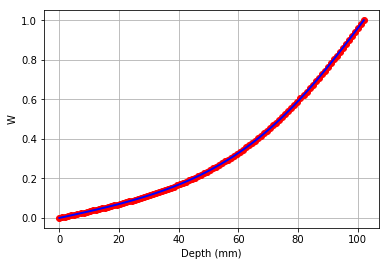

In [38]:

# take a slice through the W
x_slice = N_yelements/2
Wslice = W[int(xx),:]
Wfunc = interp1d(y, Wslice, kind='cubic')

plt.plot(y, Wfunc(y), 'ro',linewidth=1)
plt.plot(y, Wslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("W")
#plt.xlim(0, 1.1)
#plt.ylim(0, 1000)

plt.show()

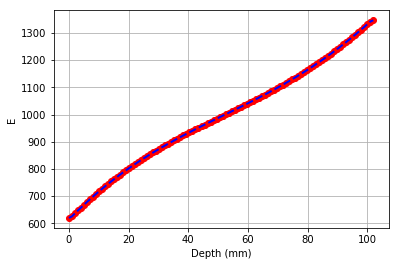

In [42]:
eps_0 = 8.85 * 10 ** (-14) 
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

#Eslice = Ez
#Eslice = np.insert(Eslice, 0, Eslice[0])
#y = np.linspace(0, N_yelements,N_yelements)

Efunc = interp1d(y, Eslice, kind='cubic')
plt.plot(y, Efunc(y), 'ro',linewidth=1)
plt.plot(y, Eslice, 'b--',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("E")
#plt.xlim(0, 16.1)
#plt.ylim(0, 1000)
plt.show()


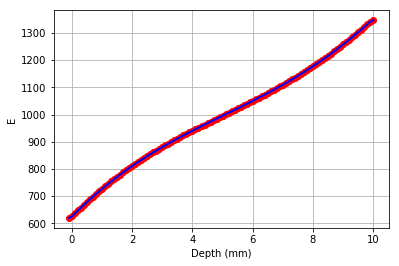

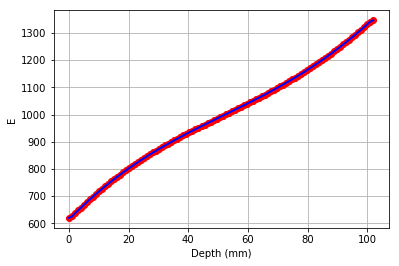

In [43]:

# take a slice through the V

Vslice = V[int(yy)]
Efunc = interp1d(y_range, Eslice, kind='cubic')

plt.plot(y_range, Efunc(y_range), 'ro',linewidth=1)
plt.plot(y_range, Eslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("E")
#plt.xlim(0, 1.1)
#plt.ylim(0, 1000)

plt.show()


Efunc = interp1d(y, Eslice, kind='cubic')

plt.plot(y, Efunc(y), 'ro',linewidth=1)
plt.plot(y, Eslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("E")
#plt.xlim(0, 1.1)
#plt.ylim(0, 1000)

z0:  50
102
0
102
50
102
51
102
52
102
53
102
54
102
55
102
56
102
57
102
58
102
59
102
60
102
61
102
62
102
63
102
64
102
65
102
66
102
67
102
68
102
69
102
70
102
71
102
72
102
73
102
74
102
75
102
76
102
77
102
78
102
79
102
80
102
81
102
82
102
83
102
84
102
85
102
86
102
87
102
88
102
89
102
90
102
91
102
92
102
93
102
94
102
95
102
96
102
97
102
98
102
99
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
102
100
100
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.7616
-0.2

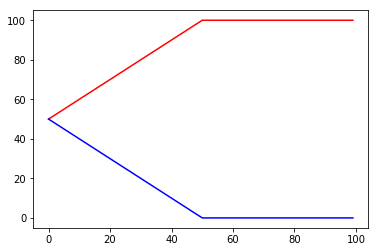

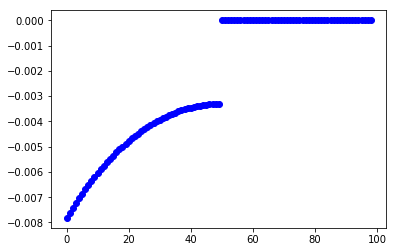

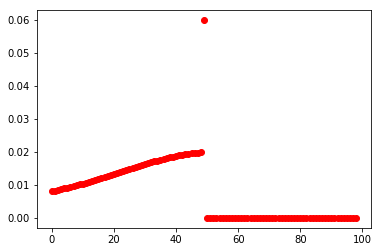

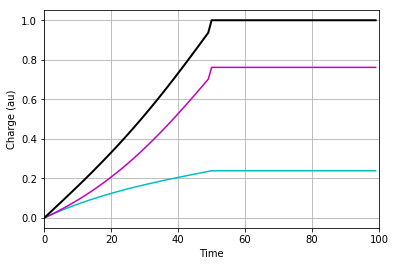

In [68]:
eps_0 = 8.85 * 10 ** (-14) 
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

# assume an interaction position at a given depth
depth_mm = detector_thickness_mm / 2
maxval = detector_thickness_mm / pixel_size_mm

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
print('z0: ',z0)

# number of time steps in signal
Nt = 100

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
w_e_vals = []
w_h_vals = []
zh = z0
ze = z0
zh_list
for t in range(1, Nt):
    print(len(Eslice))
    print(x)
    x = zh_list[-1]
    zh = zh_list[-1]
    eslice = Efunc(x)
    muh = float(hfunc(eslice))
    vh = muh * eslice
    zh = zh + 1
    #zh = np.int(zh + np.floor(vh / pixel_size_mm))

    #print(x, Eslice[x])
    #print(mue, muh)
    #print(vh)
    #print('zh', zh)

    if zh < 0:
        zh = 0
        #print('zero ', zh)
    elif zh > int(maxval):
        zh = int(maxval)
        #print('max ', zh)
    else:
        pass
    #print('zh1', zh)
    zh_list.append(zh)
    #print('=======')
    #print(zh_list)
    #print('zh2', zh)
    #x_list.append(x_list[-1] + np.floor(vh))
    if (zh== maxval) and (x!= maxval):
        dw = 1.0 - Wfunc(zh_list[t-1])
        #print('h1 ', Wfunc(zh_list[t]))
        #assert (0.9 < Wfunc(zh_list[t]) < 1.1)
        #w_h_vals.append(dw)
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
    elif (zh== maxval) and (x== maxval):
        dw = 0
        #print('h2 ',Wfunc(zh_list[t]))
        #assert (0.9 < Wfunc(zh_list[t]) < 1.1)
        #w_h_vals.append(dw)
        w_h_vals.append(0)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
    elif (zh<=N_yelements-1):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        #w_h_vals.append(dw)
        #w_h_vals.append(Wfunc(zh_list[t-1]))
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
        #print(np.cumsum(Qh)[-1])
for t in range(1, Nt):
    print(x)
    x = ze_list[-1]
    ze = ze_list[-1]
   # print(x)
    #print('zh0', zh)
    eslice = Efunc(x)
    mue = float(efunc(eslice))
    ve = mue * eslice
    ze = ze - 1
   # print('ze ', ze)
    if ze < 0:
        ze = 0
    elif ze > int(maxval):
        ze = int(maxval)
    else:
        pass
   # print('ze1 ', ze)
    ze_list.append(ze)
    if (ze== 0) and (x!= 0):
        dw = 0- Wfunc(ze_list[t-1])
        #print('e1 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        #w_e_vals.append(dw)
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
    elif (ze== 0) and (x== 0):
        dw = 0
        #print('e2 ', Wfunc(ze_list[t]))
        #assert Wfunc(ze_list[t]) == 0
        w_e_vals.append(0)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
    elif (ze<=N_yelements-1):
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        #w_e_vals.append(Wfunc(zh_list[t]))
        #w_e_vals.append(Wfunc(zh_list[t-1]))
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
        #print(np.cumsum(Qe)[-1])
print(np.cumsum(Qh)[-1])
print(np.cumsum(Qe)[-1])
# electrons out of wp

Qh = Qh
Qe = - Qe
# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)

plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()


plt.plot(w_e_vals,'bo')
plt.show()
plt.plot(w_h_vals,'ro')
plt.show()


# plot
plt.plot(Qsignal_e, 'c', linewidth=1.5)
plt.plot(Qsignal_h, 'm', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)

plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()

z0:  10
0.9663
-0.0336


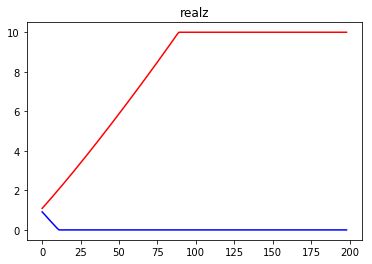

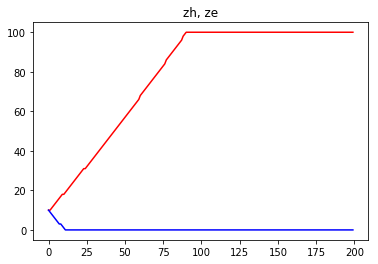

eh  1184.16337467
ee  622.655800986


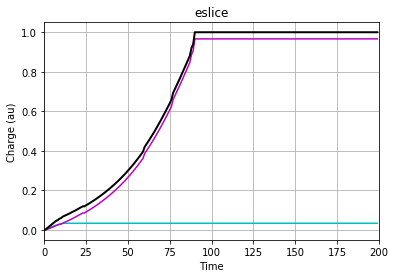

In [73]:
eps_0 = 8.85 * 10 ** (-14) # F /cm
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

# assume an interaction position at a given depth
depth_mm = detector_thickness_mm / 2
maxval = detector_thickness_mm / pixel_size_mm

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
z0 = 10
print('z0: ',z0)

# number of time steps in signal
Nt = 200

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
w_e_vals = []
w_h_vals = []
zh = z0
ze = z0
realz_list_e = []
realz_list_h = []
realz = z0 * pixel_size_mm
e_slice_list_e = []
e_slice_list_h = []

for t in range(1, Nt):
    x = zh_list[-1]
    
    eslice = Efunc(float(realz / pixel_size_mm)) # realz in pixel
    vh = float(efunc(eslice))
    
    realz += round(float(vh),6)

    if realz <= 0:
        realz = 0
    elif realz >= maxval *pixel_size_mm:
        realz = maxval*pixel_size_mm    
    
    
    realz_list_h.append(realz)
    
    zh = int(realz / pixel_size_mm)
    e_slice_list_h.append(eslice)
    if zh < 0:
        zh = 0
    elif zh > int(maxval):
        zh = int(maxval)
    else:
        pass
    zh_list.append(zh)

    if (zh== maxval) and (x!= maxval):
        dw = 1.0 - Wfunc(zh_list[t-1])
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
    elif (zh== maxval) and (x== maxval):
        dw = 0
        w_h_vals.append(0)
        Qh[t] = round(1.0*dw,4)
    elif (zh<=N_yelements-1):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        w_h_vals.append(dw)
        Qh[t] = round(1.0*dw,4)
        
realz = z0 * pixel_size_mm
for t in range(1, Nt):
    x = ze_list[-1]
    ze = ze_list[-1]

    eslice = Efunc(float(realz / pixel_size_mm)) # realz in pixel
    ve = float(efunc(eslice))

    realz += round(float(-1 * ve),6)
    
    if realz < 0:
        realz = 0
    elif realz > maxval:
        realz = maxval
    realz_list_e.append(realz)
    ze = int(realz/ pixel_size_mm)
    e_slice_list_e.append(eslice)
    
    if ze < 0:
        ze = 0
    elif ze > int(maxval):
        ze = int(maxval)
    else:
        pass
    ze_list.append(ze)
    if (ze== 0) and (x!= 0):
        dw = 0- Wfunc(ze_list[t-1])
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
    elif (ze== 0) and (x== 0):
        dw = 0
        w_e_vals.append(0)
        Qe[t] = round(1.0*dw,4)
    elif (ze<=N_yelements-1):
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        w_e_vals.append(dw)
        Qe[t] = round(1.0*dw,4)
        
print(np.cumsum(Qh)[-1])
print(np.cumsum(Qe)[-1])
# electrons out of wp

Qh = Qh
Qe = - Qe
# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)


plt.title('realz')
plt.plot(realz_list_h,'r-')
plt.plot(realz_list_e,'b-')
plt.show()


plt.title('zh, ze')
plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()


plt.title('eslice')
print('eh ', np.mean(e_slice_list_h))
print('ee ', np.mean(e_slice_list_e))
#plt.plot(w_e_vals,'bo')
#plt.show()
#plt.plot(w_h_vals,'ro')
#plt.show()


# plot
plt.plot(Qsignal_e, 'c', linewidth=1.5)
plt.plot(Qsignal_h, 'm', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)

plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()

In [83]:
print(np.linspace(5, 100, 20))

[   5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.   60.
   65.   70.   75.   80.   85.   90.   95.  100.]


z0:  0.0
1.0
0.0


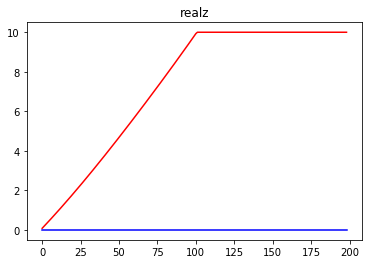

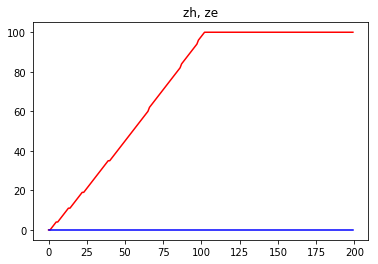

eh  1144.34983489
ee  619.639813424


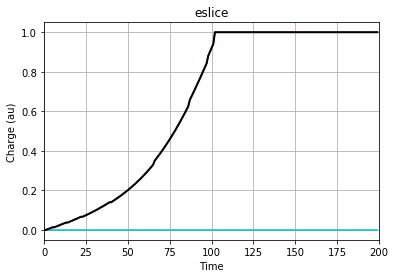

z0:  2.4358974359
0.9919
-0.0081


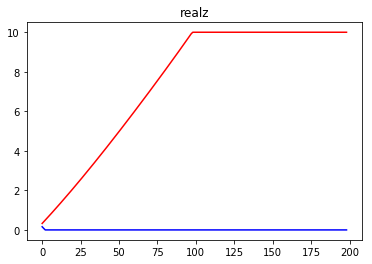

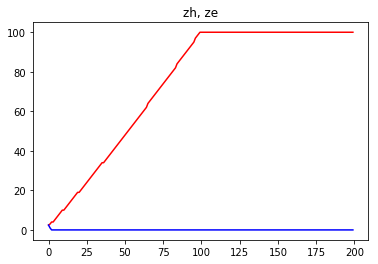

eh  1154.84463447
ee  619.822832673


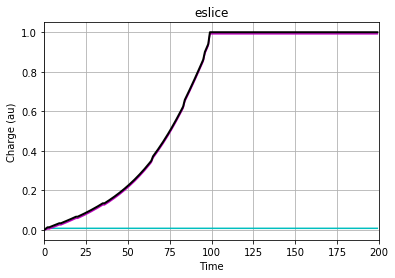

z0:  4.87179487179
0.9837
-0.0161


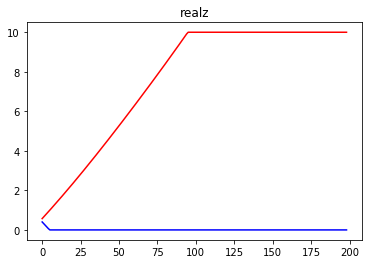

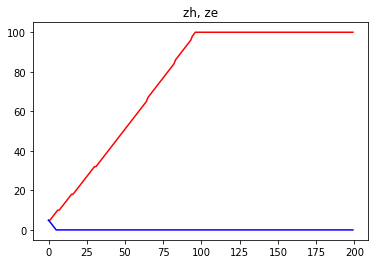

eh  1164.81544076
ee  620.379076937


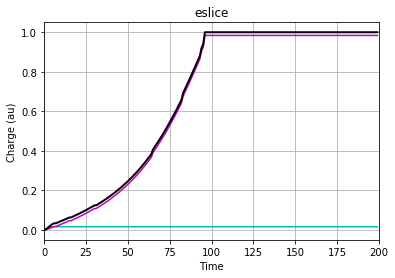

z0:  7.30769230769
0.9758
-0.0243


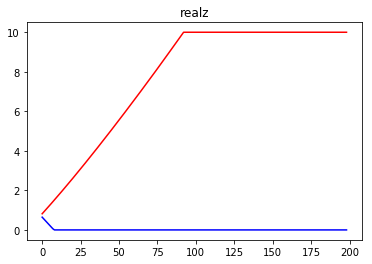

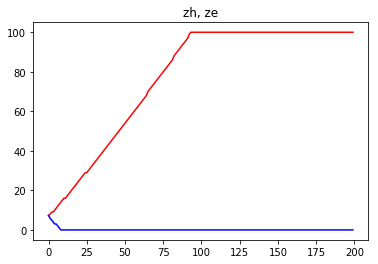

eh  1174.27011199
ee  621.282602269


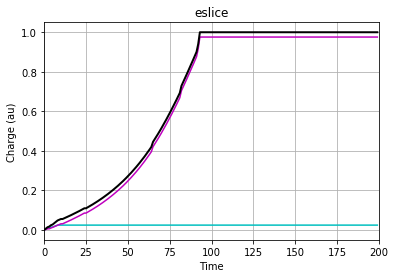

z0:  9.74358974359
0.9674
-0.0327


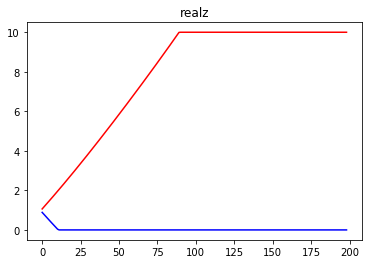

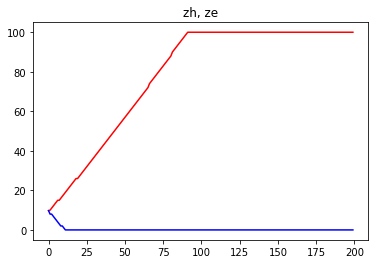

eh  1183.2475413
ee  622.508637757


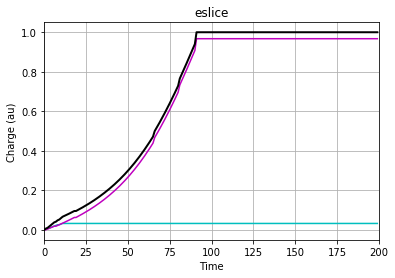

z0:  12.1794871795
0.9587
-0.0413


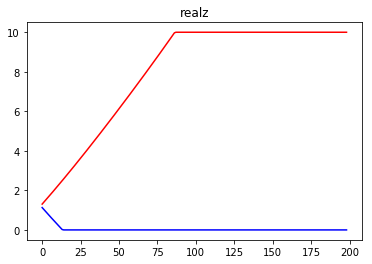

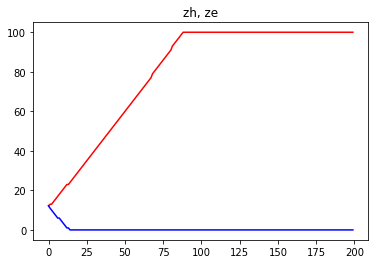

eh  1191.78055768
ee  624.034759129


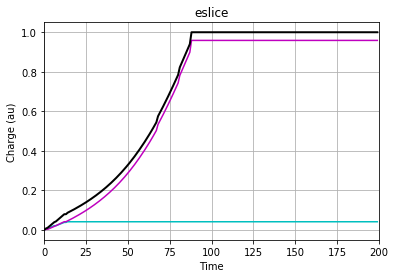

z0:  14.6153846154
0.9499
-0.05


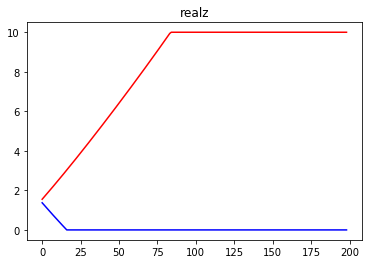

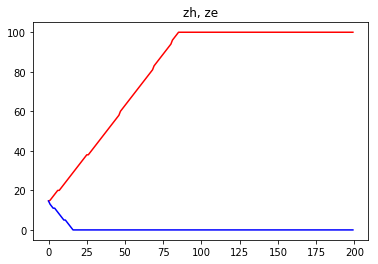

eh  1199.90811968
ee  625.84081735


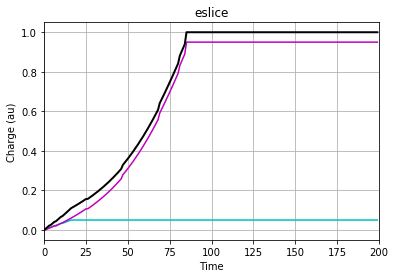

z0:  17.0512820513
0.9409
-0.0591


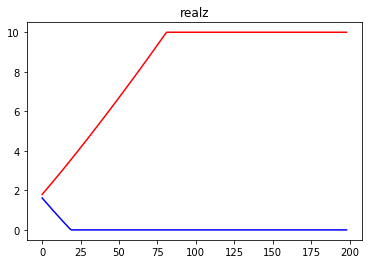

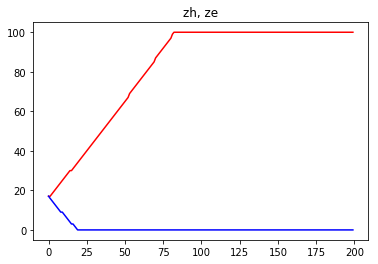

eh  1207.65855241
ee  627.907227584


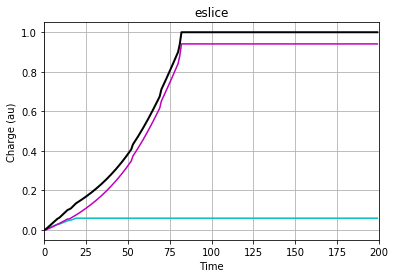

z0:  19.4871794872
0.9312
-0.0686


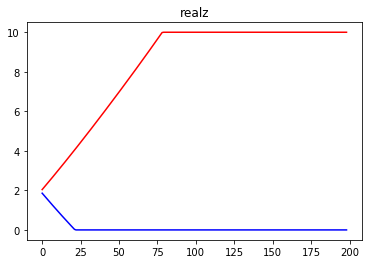

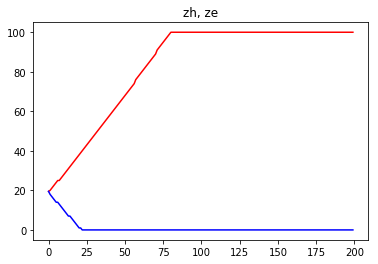

eh  1215.05016604
ee  630.215142434


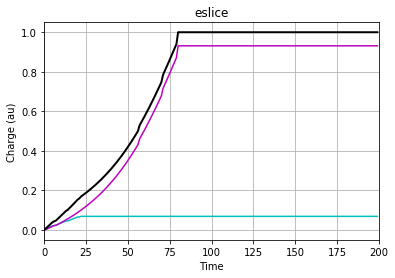

z0:  21.9230769231
0.9217
-0.0784


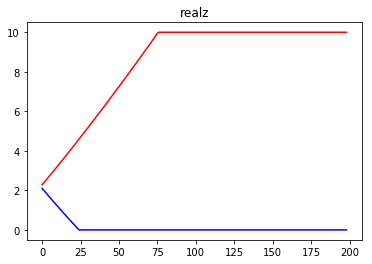

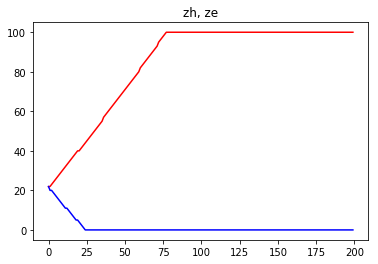

eh  1222.10452306
ee  632.749866609


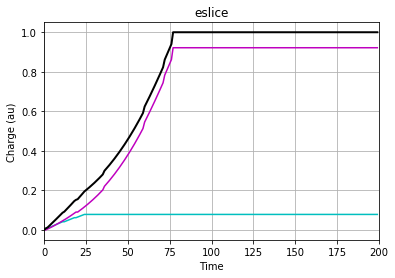

z0:  24.358974359
0.9116
-0.0886


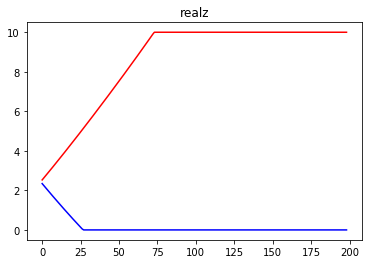

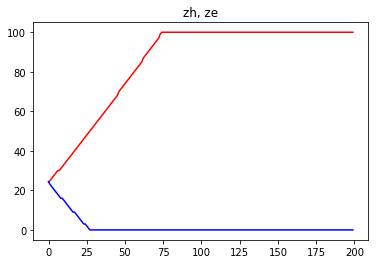

eh  1228.85451601
ee  635.497218704


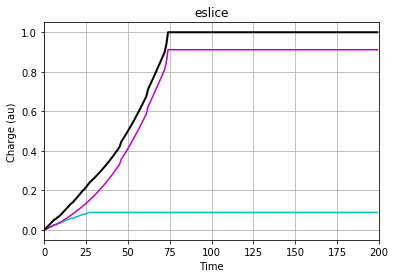

z0:  26.7948717949
0.9006
-0.0992


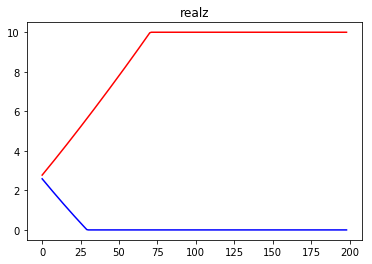

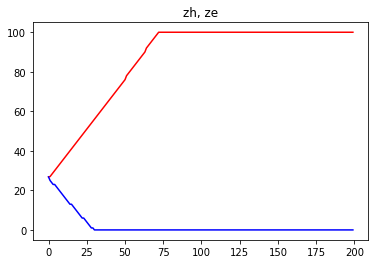

eh  1235.3063291
ee  638.442684843


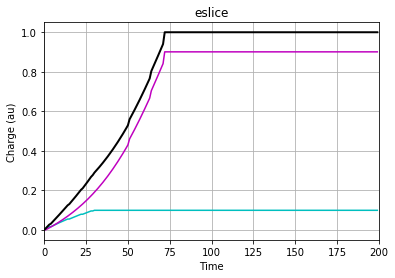

z0:  29.2307692308
0.8892
-0.1106


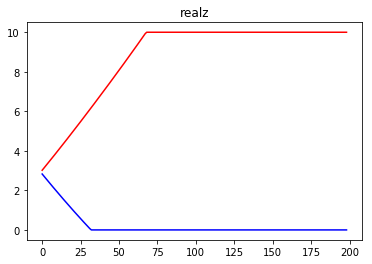

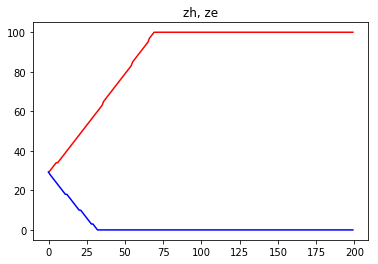

eh  1241.48485818
ee  641.577026995


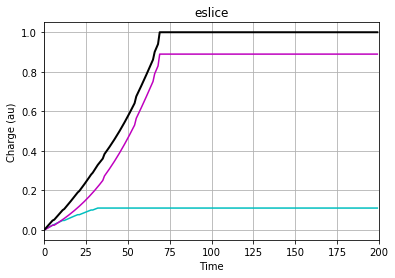

z0:  31.6666666667
0.8774
-0.1225


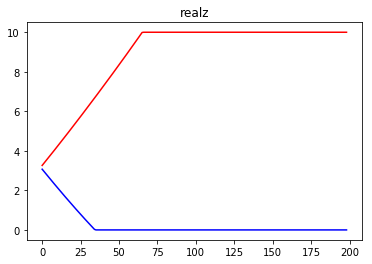

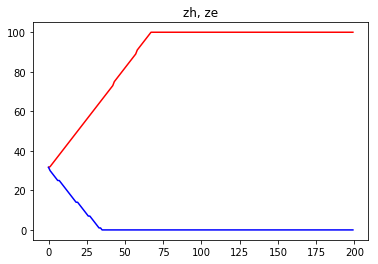

eh  1247.40893528
ee  644.88795925


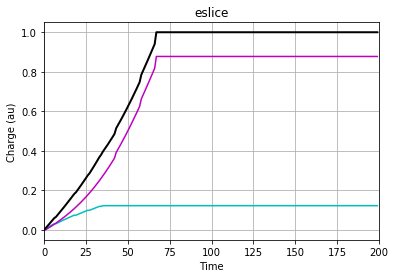

z0:  34.1025641026
0.8649
-0.1351


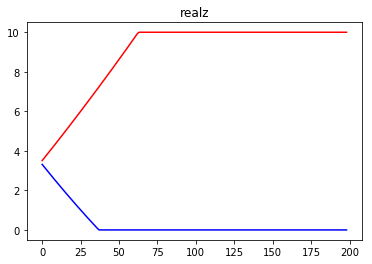

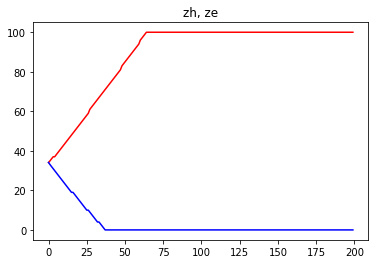

eh  1253.08128204
ee  648.368352324


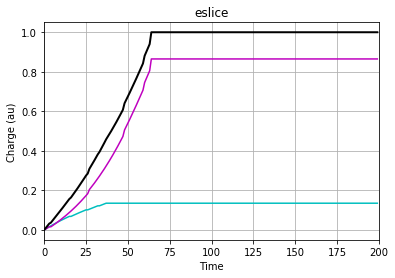

z0:  36.5384615385
0.8517
-0.1484


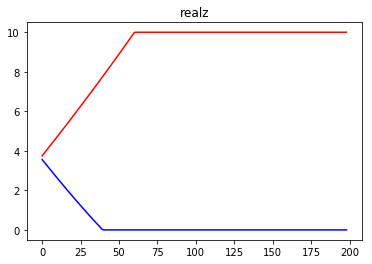

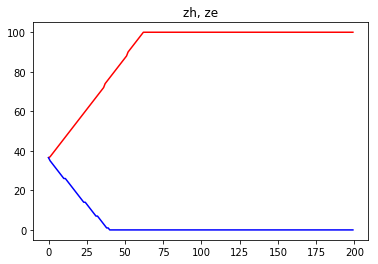

eh  1258.53172801
ee  652.009157731


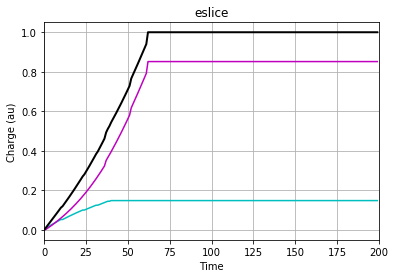

z0:  38.9743589744
0.8375
-0.1625


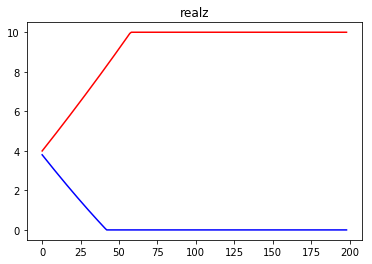

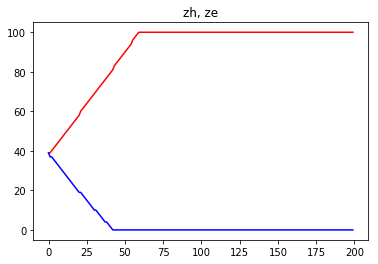

eh  1263.75044944
ee  655.804906142


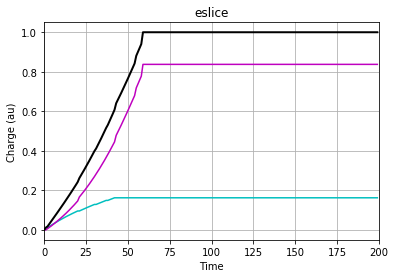

z0:  41.4102564103
0.8226
-0.1775


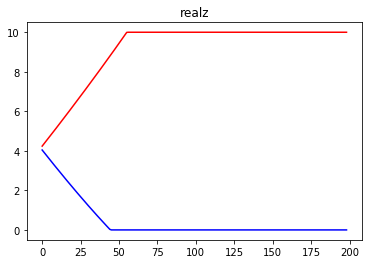

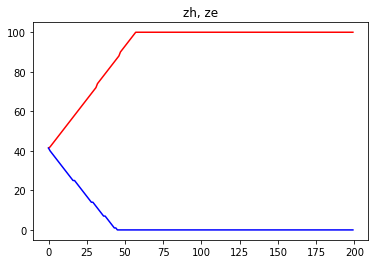

eh  1268.76946673
ee  659.74895548


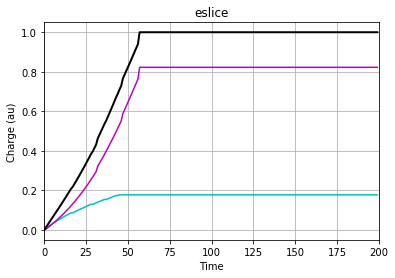

z0:  43.8461538462
0.8065
-0.1935


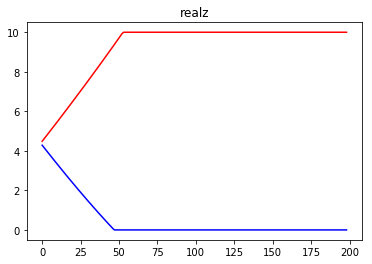

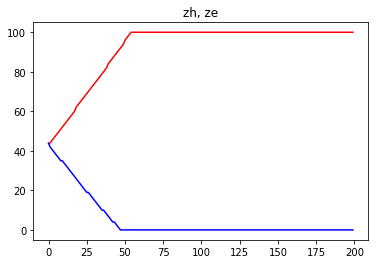

eh  1273.57555298
ee  663.837992868


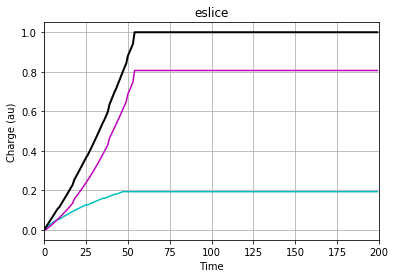

z0:  46.2820512821
0.7894
-0.2105


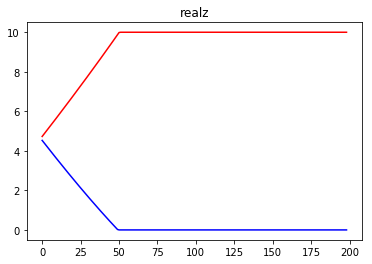

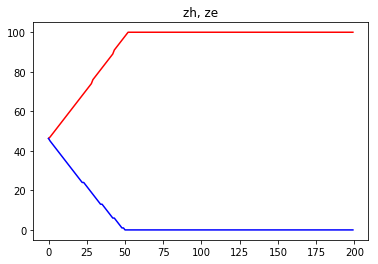

eh  1278.19493534
ee  668.066734229


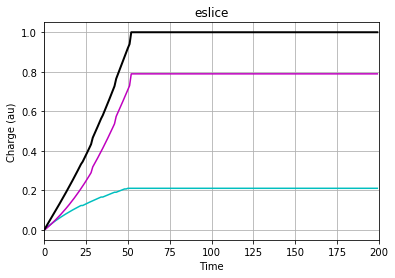

z0:  48.7179487179
0.7714
-0.2285


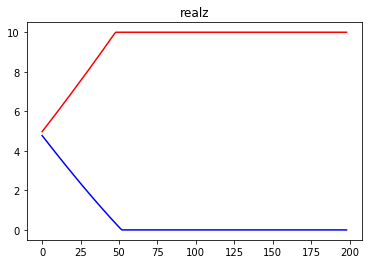

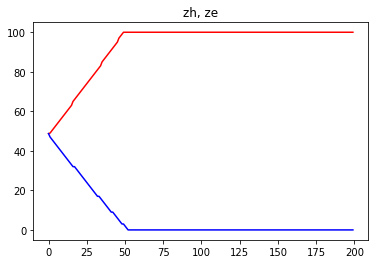

eh  1282.61886642
ee  672.434547165


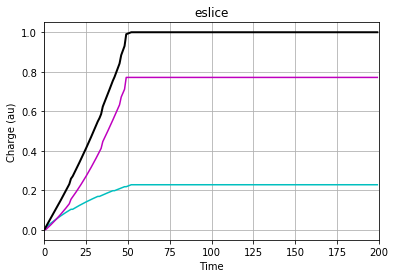

z0:  51.1538461538
0.7524
-0.2477


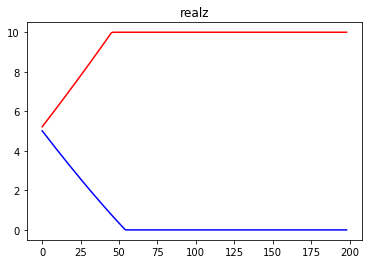

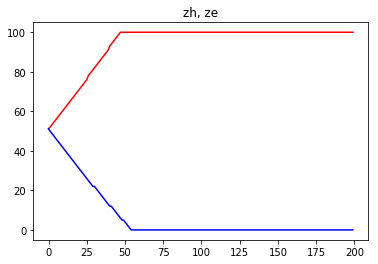

eh  1286.86079619
ee  676.937083871


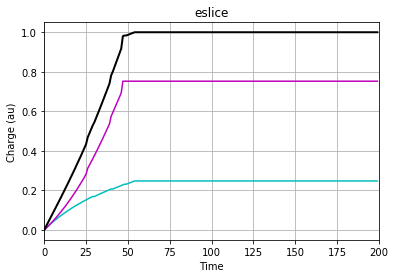

z0:  53.5897435897
0.7319
-0.2681


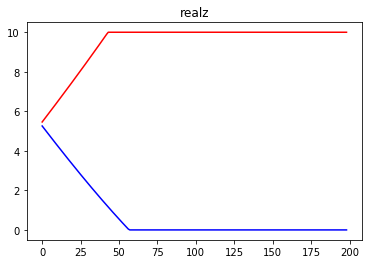

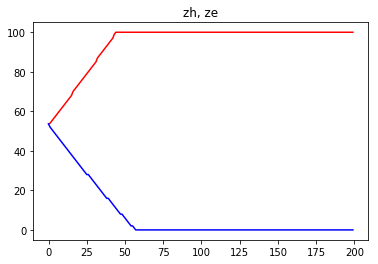

eh  1290.9234627
ee  681.575912866


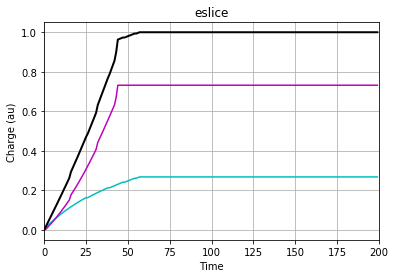

z0:  56.0256410256
0.7099
-0.2901


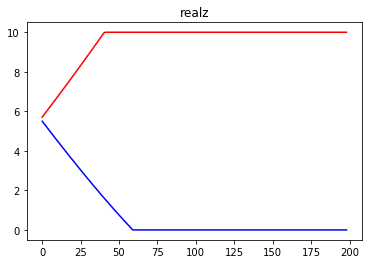

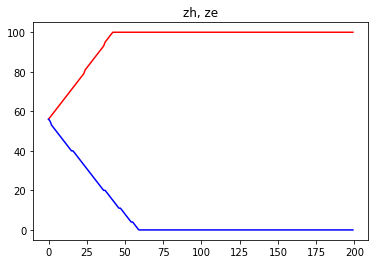

eh  1294.80172109
ee  686.348866969


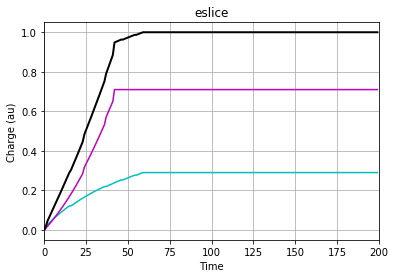

z0:  58.4615384615
0.6868
-0.3134


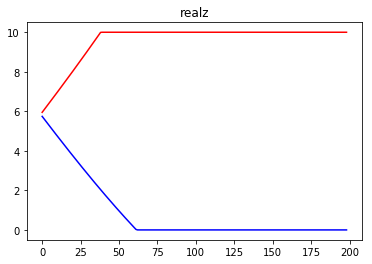

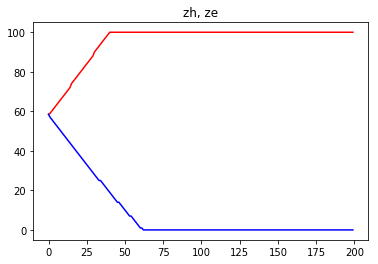

eh  1298.51195511
ee  691.256986259


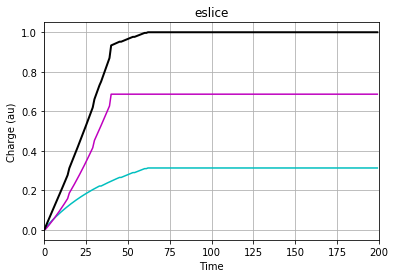

z0:  60.8974358974
0.6617
-0.3382


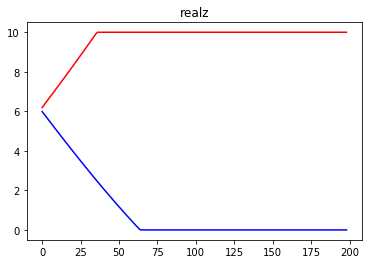

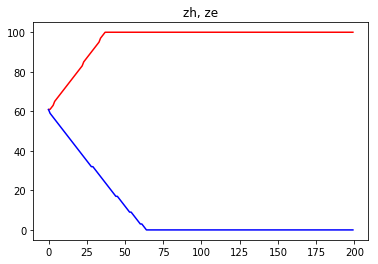

eh  1302.03593146
ee  696.302326414


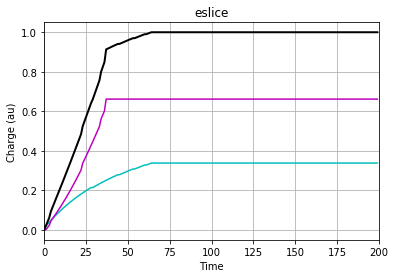

z0:  63.3333333333
0.6355
-0.3645


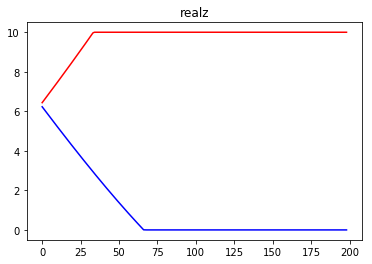

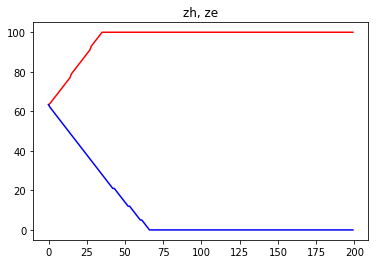

eh  1305.38734294
ee  701.484540735


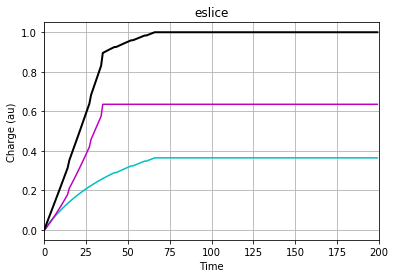

z0:  65.7692307692
0.6075
-0.3925


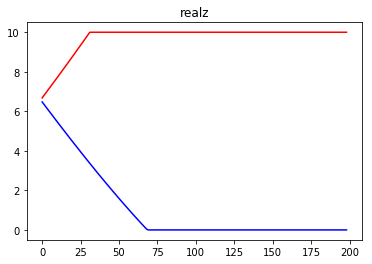

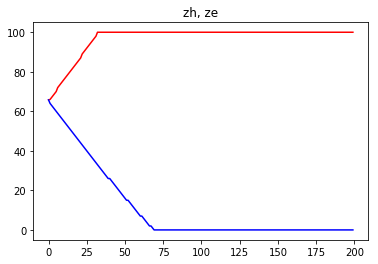

eh  1308.56595169
ee  706.808317986


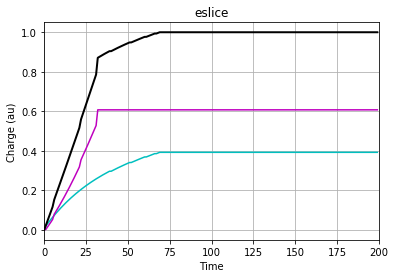

z0:  68.2051282051
0.5777
-0.4223


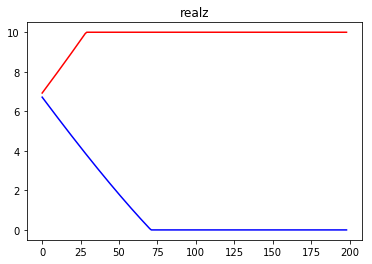

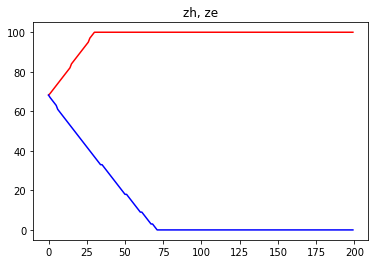

eh  1311.55370734
ee  712.275552981


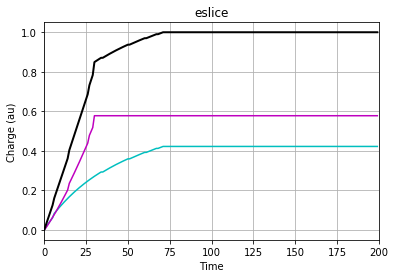

z0:  70.641025641
0.5464
-0.4537


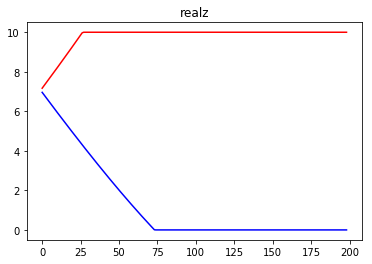

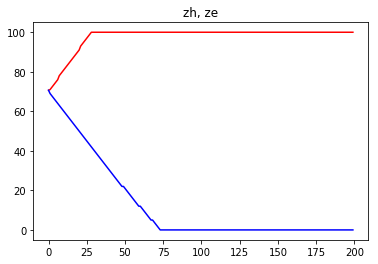

eh  1314.36503712
ee  717.888753027


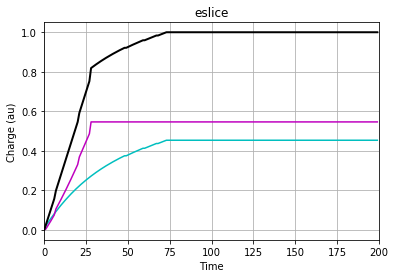

z0:  73.0769230769
0.5133
-0.4869


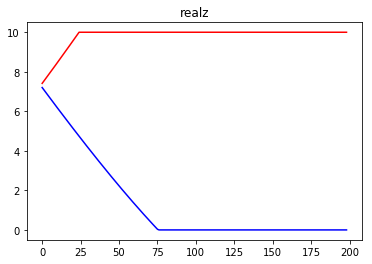

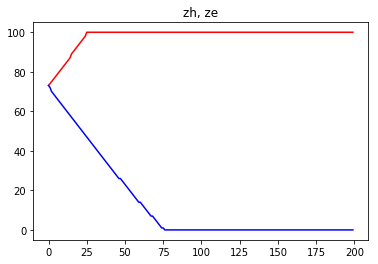

eh  1316.99353449
ee  723.653721304


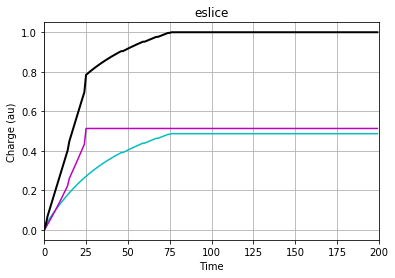

z0:  75.5128205128
0.478
-0.5218


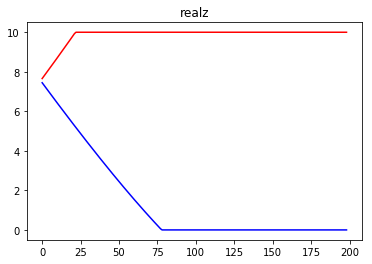

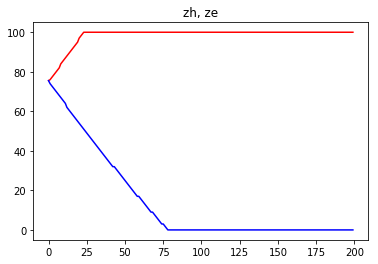

eh  1319.42156748
ee  729.574189582


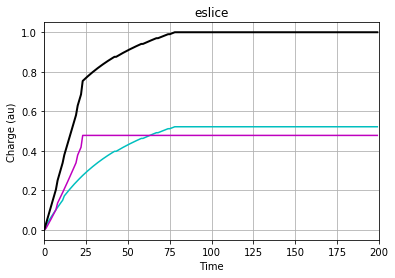

z0:  77.9487179487
0.4413
-0.5587


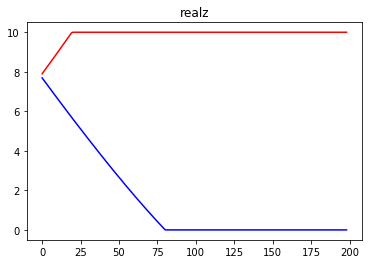

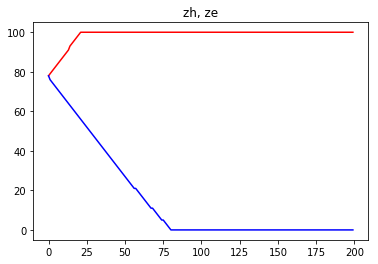

eh  1321.65960524
ee  735.653568824


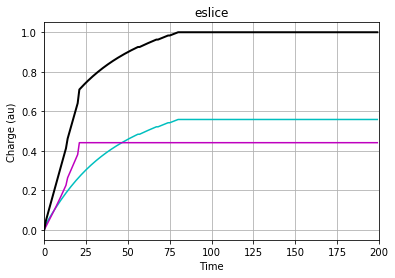

z0:  80.3846153846
0.4025
-0.5976


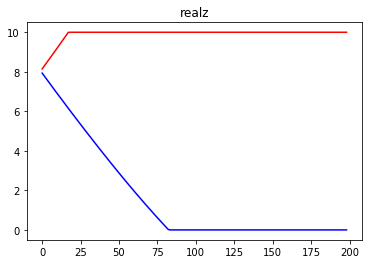

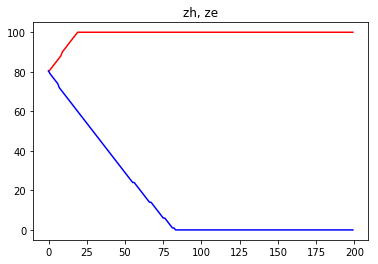

eh  1323.70202191
ee  741.898787582


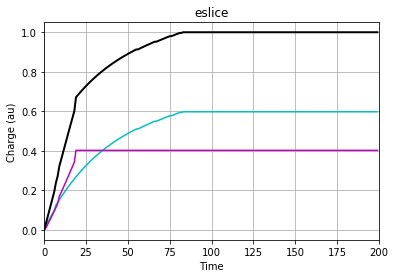

z0:  82.8205128205
0.3621
-0.6378


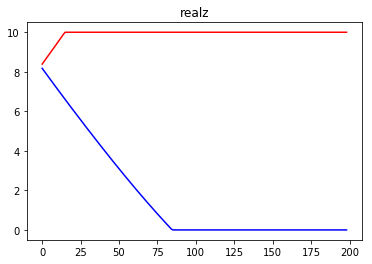

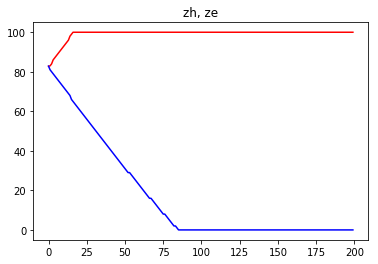

eh  1325.52864116
ee  748.314791296


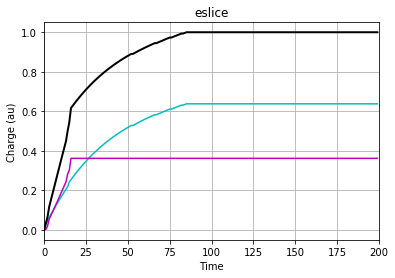

z0:  85.2564102564
0.3202
-0.6799


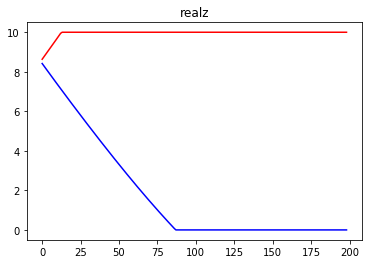

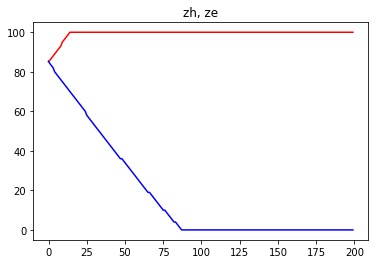

eh  1327.14458365
ee  754.90588132


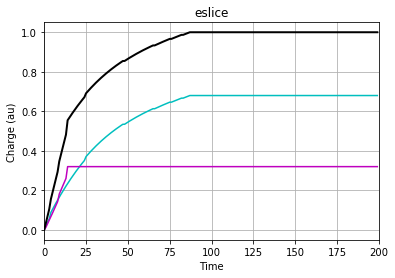

z0:  87.6923076923
0.2767
-0.7232


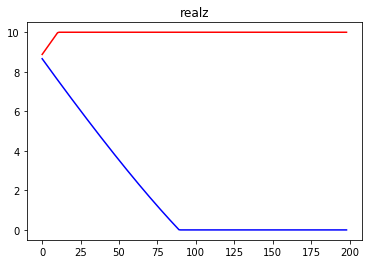

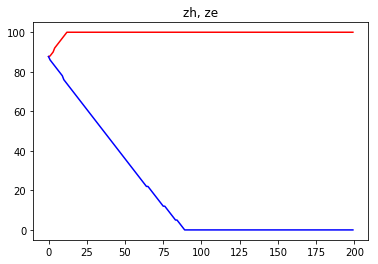

eh  1328.54537192
ee  761.677585766


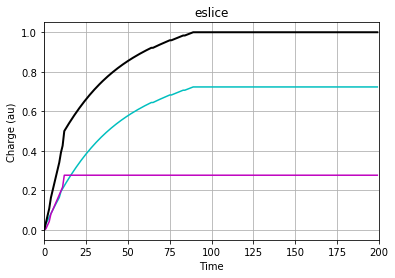

z0:  90.1282051282
0.2318
-0.7682


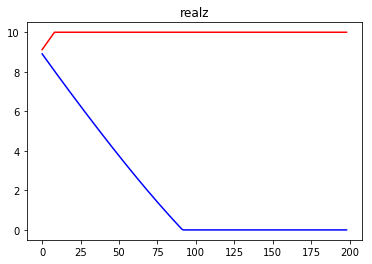

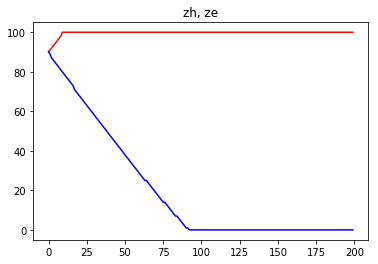

eh  1329.72271566
ee  768.636280964


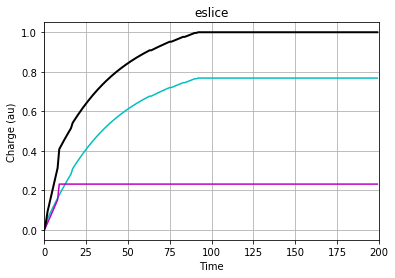

z0:  92.5641025641
0.1857
-0.8143


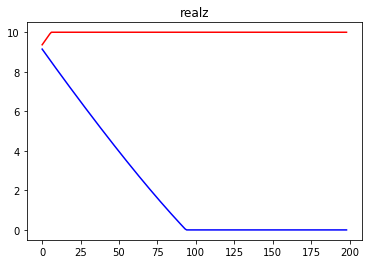

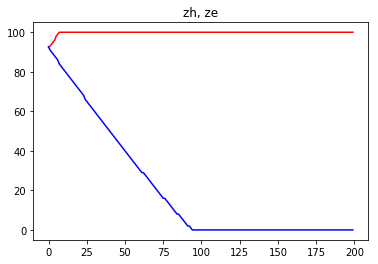

eh  1330.65808001
ee  775.786325062


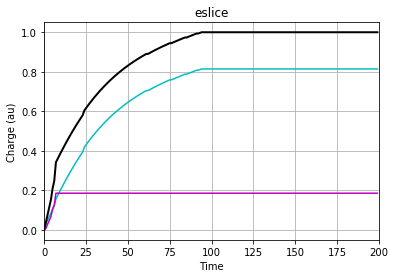

z0:  95.0
0.1387
-0.8613


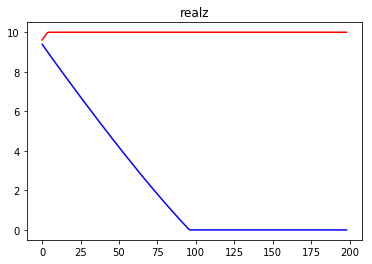

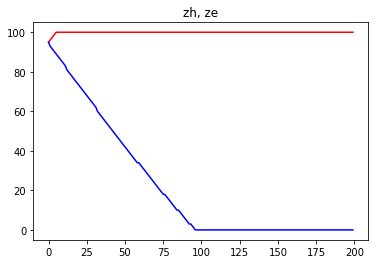

eh  1331.35696566
ee  783.131731689


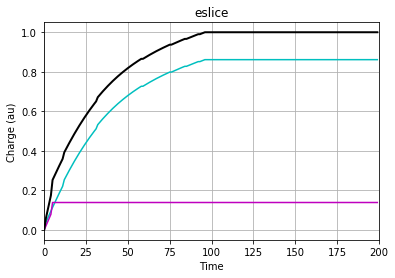

In [119]:
eps_0 = 8.85 * 10 ** (-14) # F /cm
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V


# number of time steps in signal
Nt = 200
z_values = np.linspace(0, 95, 40)
all_signals = np.zeros((len(z_values), Nt))
all_signals_e = np.zeros((len(z_values), Nt))
all_signals_h = np.zeros((len(z_values), Nt))

# assume an interaction position at a given depth
depth_mm = detector_thickness_mm / 2
maxval = detector_thickness_mm / pixel_size_mm

z0 = np.int(np.floor(depth_mm / pixel_size_mm))

for i in range(0, len(z_values)):
    z0 = z_values[i]
    #z0 = np.int(np.floor(i / pixel_size_mm))
    print('z0: ',z0)
    
    # arrays which will store the induced charge signals
    Qh = np.zeros(Nt, dtype=float)
    Qe = np.zeros(Nt, dtype=float)

    # starting positions for electrons and holes
    zh_list = []
    ze_list = []
    zh_list.append(z0)
    ze_list.append(z0)
    # holes into wp
    t = 0
    w_e_vals = []
    w_h_vals = []
    zh = z0
    ze = z0
    realz_list_e = []
    realz_list_h = []
    realz = z0 * pixel_size_mm
    e_slice_list_e = []
    e_slice_list_h = []

    for t in range(1, Nt):
        x = zh_list[-1]
    
        eslice = Efunc(float(realz / pixel_size_mm)) # realz in pixel
        vh = float(efunc(eslice))
    
        realz += round(float(vh),6)

        if realz <= 0:
            realz = 0
        elif realz >= maxval *pixel_size_mm:
            realz = maxval*pixel_size_mm    
    
    
        realz_list_h.append(realz)
        
        zh = int(realz / pixel_size_mm)
        e_slice_list_h.append(eslice)
        if zh < 0:
            zh = 0
        elif zh > int(maxval):
            zh = int(maxval)
        else:
            pass
        zh_list.append(zh)

        if (zh== maxval) and (x!= maxval):
            dw = 1.0 - Wfunc(zh_list[t-1])
            w_h_vals.append(dw)
            Qh[t] = round(1.0*dw,4)
        elif (zh== maxval) and (x== maxval):
            dw = 0
            w_h_vals.append(0)
            Qh[t] = round(1.0*dw,4)
        elif (zh<=N_yelements-1):
            dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
            w_h_vals.append(dw)
            Qh[t] = round(1.0*dw,4)
        
    realz = z0 * pixel_size_mm
    for t in range(1, Nt):
        x = ze_list[-1]
        ze = ze_list[-1]

        eslice = Efunc(float(realz / pixel_size_mm)) # realz in pixel
        ve = float(efunc(eslice))
    
        realz += round(float(-1 * ve),6)
    
        if realz < 0:
            realz = 0
        elif realz > maxval:
            realz = maxval
        realz_list_e.append(realz)
        ze = int(realz/ pixel_size_mm)
        e_slice_list_e.append(eslice)
    
        if ze < 0:
            ze = 0
        elif ze > int(maxval):
            ze = int(maxval)
        else:
            pass
        ze_list.append(ze)
        if (ze== 0) and (x!= 0):
            dw = 0- Wfunc(ze_list[t-1])
            w_e_vals.append(dw)
            Qe[t] = round(1.0*dw,4)
        elif (ze== 0) and (x== 0):
            dw = 0
            w_e_vals.append(0)
            Qe[t] = round(1.0*dw,4)
        elif (ze<=N_yelements-1):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(dw)
            Qe[t] = round(1.0*dw,4)
        
    print(np.cumsum(Qh)[-1])
    print(np.cumsum(Qe)[-1])
    # electrons out of wp

    Qh = Qh
    Qe = - Qe
    # take cumulative sums
    Qsignal_h = np.cumsum(Qh)
    Qsignal_e = np.cumsum(Qe)
    Qsignal = np.cumsum(Qe + Qh)

    all_signals[i] = Qsignal 
    all_signals_e[i] = Qsignal_e 
    all_signals_h[i] = Qsignal_h
    
    plt.title('realz')
    plt.plot(realz_list_h,'r-')
    plt.plot(realz_list_e,'b-')
    plt.show()


    plt.title('zh, ze')
    plt.plot(zh_list,'r-')
    plt.plot(ze_list,'b-')
    plt.show()


    plt.title('eslice')
    print('eh ', np.mean(e_slice_list_h))
    print('ee ', np.mean(e_slice_list_e))
#plt.plot(w_e_vals,'bo')
#plt.show()
#plt.plot(w_h_vals,'ro')
#plt.show()


# plot
    plt.plot(Qsignal_e, 'c', linewidth=1.5)
    plt.plot(Qsignal_h, 'm', linewidth=1.5)
    plt.plot(Qsignal, 'k', linewidth=2)

    plt.grid("on")
#plt.ylim(0,1)
    plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
    plt.xlabel("Time")
    plt.ylabel("Charge (au)")
#plt.legend()
    plt.show()

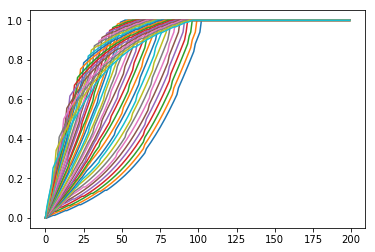

/home/anp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


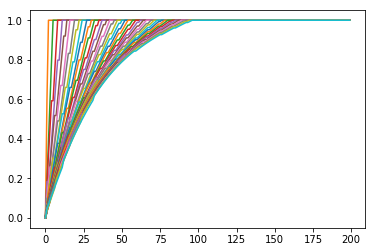

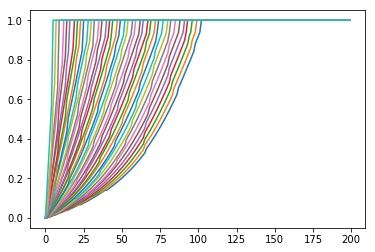

In [120]:
for i in all_signals:
    plt.plot(i)
plt.show()

for i in all_signals_e:
    i = i / np.amax(i)
    plt.plot(i)
plt.show()

for i in all_signals_h:
    i = i / np.amax(i)
    plt.plot(i)
plt.show()

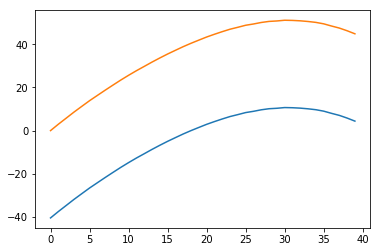

In [134]:
chi2 = []
for i in range(0, 40,1):
    chix = np.sum(all_signals[i] - all_signals[18])
    chi2.append(chix)
    #print(chix)
plt.plot(chi2)
#plt.show()

chi2 = []
for i in range(0, 40,1):
    chix = np.sum(all_signals[i] - all_signals[0])
    chi2.append(chix)
    #print(chix)
plt.plot(chi2)
plt.show()

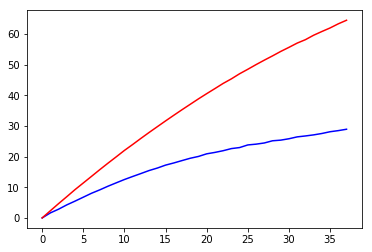

In [122]:
chi2_e = []
for i in range(1, 39,1):
    max1 =  np.amax(all_signals_e[i])
    max0 =  np.amax(all_signals_e[1])
    #print(max1, max0)
    sig1 = all_signals_e[i] / max1
    sig0 = all_signals_e[1] / max0
    chix = abs(np.sum(sig0-sig1)) 
    chi2_e.append(chix)
plt.plot(chi2_e, 'b')

chi2_h = []
for i in range(1, 39,1):
    sig1 = all_signals_h[i] / np.amax(all_signals_h[i])
    sig0 = all_signals_h[1] / np.amax(all_signals_h[1])
    chix = abs(np.sum(sig0-sig1))
    chi2_h.append(chix)
plt.plot(chi2_h, 'r')

plt.show()

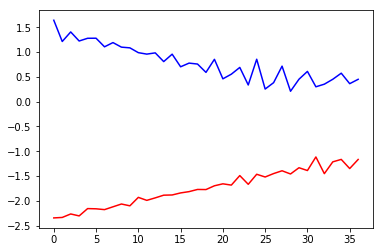

In [126]:
chi2_e = []
for i in range(2, 39,1):
    max1 =  np.amax(all_signals_e[i])
    max0 =  np.amax(all_signals_e[i-1])
    #print(max1, max0)
    sig1 = all_signals_e[i] / max1
    sig0 = all_signals_e[i-1] / max0
    chix = (np.sum(sig0-sig1)) 
    chi2_e.append(chix)
plt.plot(chi2_e, 'b')

chi2_h = []
for i in range(2, 39,1):
    sig1 = all_signals_h[i] / np.amax(all_signals_h[i])
    sig0 = all_signals_h[i-1] / np.amax(all_signals_h[i-1])
    chix = (np.sum(sig0-sig1))
    chi2_h.append(chix)
plt.plot(chi2_h, 'r')

plt.show()

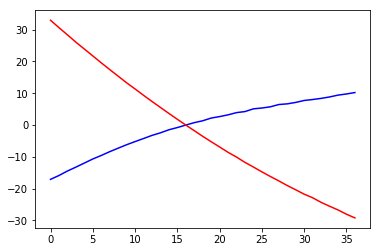

In [127]:
chi2_e = []
for i in range(2, 39,1):
    max1 =  np.amax(all_signals_e[i])
    max0 =  np.amax(all_signals_e[18])
    #print(max1, max0)
    sig1 = all_signals_e[i] / max1
    sig0 = all_signals_e[18] / max0
    chix = (np.sum(sig0-sig1)) 
    chi2_e.append(chix)
plt.plot(chi2_e, 'b')

chi2_h = []
for i in range(2, 39,1):
    sig1 = all_signals_h[i] / np.amax(all_signals_h[i])
    sig0 = all_signals_h[18] / np.amax(all_signals_h[18])
    chix = (np.sum(sig0-sig1))
    chi2_h.append(chix)
plt.plot(chi2_h, 'r')

plt.show()

In [ ]:
ristime_diffs = []

for i in range(0, 17):
    t50_e = 0
    t50_h = 0
    
    Qsignal = Qsignal_arr[i]
    
    high = 0
    low = 0
    
    #plt.plot(Qsignal_h)
    #plt.plot(Qsignal_e)
    #plt.show()
    
    
    for j in range(0, len(Qsignal)):
        #print(j)
        #print(Qsignal_e[j])
        #print(0.5*np.amax(Qsignal_e))
        if Qsignal[j] < 0.5*np.amax(Qsignal):
            low = j
        if Qsignal[j] > 0.5*np.amax(Qsignal):
            high = j
            break

    t50_1 = (high + low) / 2.0  # ns
    
    ristime_diffs.append(t50_1 )#- t50_2)
    

In [ ]:
plt.plot(ristime_diffs,'-')
plt.show()

In [ ]:
# set some detector parameters
strip_width_mm = 2.8
strip_gap_mm = 0.2
detector_thickness_mm = 16.0 #16.0
pixel_size_mm = 0.1

# set detector width to n*pitch where n is an odd number
detector_width_mm = (3*strip_width_mm+strip_gap_mm)


# In[204]:


# build some grids
x_range = np.arange(-detector_width_mm/2 + pixel_size_mm, detector_width_mm/2 + pixel_size_mm, pixel_size_mm)
y_range = np.arange(-pixel_size_mm, detector_thickness_mm + pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)
W = np.zeros((N_xelements, N_yelements), dtype=float)
E = np.zeros((N_xelements, N_yelements), dtype=float)


# In[205]:


# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# continous contact
geom_map[:,0] = 3

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,0] = 3

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,0] = 3

# strip surface
geom_map[:,-1] = 2

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,-1] = 2

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,-1] = 2

# strip
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,0] = 1

# gap
ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4

ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,0] = 4


# In[206]:


# set boundary conditions

# non-strip contacts
[ix,iy] = np.where(geom_map == 2)
W[ix,iy] = 0
V[ix,iy] = 0

# back face
[ix,iy] = np.where(geom_map == 3)
W[ix,iy] = 0
V[ix,iy] = 1000

# strip
[ix,iy] = np.where(geom_map == 1)
W[ix,iy] = 1
V[ix,iy] = 0


# In[207]:


# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):

    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):

            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue

            # should deal with some boundary conditions...

            V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])

            # update the solution
            R[x,y] = 0.25*V_local_sum - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]

    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid

    # update iteration counter
    iterr+=1


# In[208]:


# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.savefig('finaldiff1.pdf')
plt.cla()
plt.clf()
#plt.show()

# also print the final difference
print("Final Difference:")
print(resid_store[-1])


# In[ ]:





# In[210]:


# do the relaxation
# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):

    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):

            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue

            # should deal with some boundary conditions...

            W_local_sum = (W[x+1,y] + W[x,y+1] + W[x-1,y] + W[x,y-1])

            # update the solution
            R[x,y] = 0.25*W_local_sum - W[x,y]
            W[x,y] = W[x,y] + w*R[x,y]

    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid

    # update iteration counter
    iterr+=1


# In[211]:


# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.savefig('diff2.pdf')
plt.cla()
plt.clf()
#plt.show()

# also print the final difference
print("Final Difference:")
print(resid_store[-1])


# In[212]:


X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, V, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()


# In[213]:


X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, W, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()


# In[254]:


# take a slice through the V
x_slice = 125
Vslice = V[x_slice,:]

plt.plot(y_range, Vslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
plt.xlim(0, 16.1)
plt.ylim(0, 1000)
plt.show()

# take a slice through the V
x_slice = 125
Vslice = V[x_slice,:]
Vfunc = interp1d(y_range, Vslice, kind='cubic')

plt.plot(y_range, Vslice, 'b-',linewidth=2)
plt.plot(y_range, Vfunc(y_range), 'ro',linewidth=1)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
plt.xlim(0, 1.1)
plt.ylim(0, 1000)

plt.show()


# In[297]:


#print(len(Eslice))
#print(len(Vslice))
#print(len(y))
# take a slice through the WP

x_slice = N_xelements/2
Eslice = -1 * np.gradient(Vslice) #V[x_slice,:]
#Eslice = np.insert(Eslice, 0, Eslice[0])
y = np.linspace(0, N_yelements,N_yelements)

Efunc = interp1d(y, Eslice, kind='cubic')
plt.plot(y, Efunc(y), 'ro',linewidth=1)

#print(y)
plt.plot(y, Eslice, 'b--',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
#plt.xlim(0, 16.1)
#plt.ylim(0, 1000)
plt.show()


# In[298]:


# take a slice through the WP

x_slice = N_xelements/2
Wslice = W[x_slice,:]

y = np.linspace(0, N_yelements,N_yelements)

Wfunc = interp1d(y, Wslice, kind='cubic')
plt.plot(y, Wfunc(y), 'ro',linewidth=1)

#print(y)
plt.plot(y, Wslice, 'b--',linewidth=2)

#plt.plot(y, Wslice, 'bo',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("W")
#plt.xlim(0, 1)
#plt.ylim(0, 0.1)
plt.show()


# In[322]:


eps_0 = 8.85 * 10 ** (-14)
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
#Voltage = 1000 # V

# assume an interaction position at a given depth
depth_mm = 0.2

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
print('z0: ',z0)
maxval = 1.0 / pixel_size_mm

# number of time steps in signal
Nt = 200

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
x_list = []
zh = z0
ze = z0
w_e_vals = []
w_h_vals = []
for t in range(1, Nt):
    x = zh_list[-1]
    eslice = Efunc(x)
    muh = float(hfunc(eslice))
    vh = muh * eslice
    zh = np.int(zh + np.floor(vh / pixel_size_mm))

    #print(x, Eslice[x])
    #print(mue, muh)
    #print(vh)
    #print('zh', zh)

    if zh <= 0:
        zh = 0
    if zh >= int(maxval):
        zh = int(maxval)
    zh_list.append(zh)
    #x_list.append(x_list[-1] + np.floor(vh))
    if (zh== maxval) and (x== maxval):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        w_h_vals.append(1.0)
        Qh[t] = round(1.0*dw,4)
    elif (zh<=N_yelements-1):
        dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
        w_h_vals.append(Wfunc(zh_list[t]))
        w_h_vals.append(Wfunc(zh_list[t-1]))
        Qh[t] = round(1.0*dw,4)

# electrons out of wp
t = 0
for t in range(1, Nt):
    x = ze_list[-1]
    eslice = Efunc(x)
    mue = float(efunc(eslice))
    ve = mue * eslice
    ze = np.int(ze - np.floor(ve / pixel_size_mm))

    if ze <= 0:
        ze = 0
    if ze >= int(maxval):
        ze = int(maxval)
    ze_list.append(ze)
    #x_list.append(x_list[-1] + np.floor(vh))
    if (ze== 0)and( x!= 0):
        #print('min')
        #print(ze_list[t])
        #print(ze_list[t-1])
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        w_e_vals.append(1.0)
        Qe[t] = round(1.0*dw,4)
        #print(dw)
        #print(np.cumsum(Qe)[-1])
       # continue
    elif (ze== 0)and( x== 0):
        dw = 0.0
        w_e_vals.append(1.0)
        Qe[t] = -1 * round(1.0*dw,2)

    elif (ze<=N_yelements-1):
        dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
        w_e_vals.append(Wfunc(ze_list[t]))
        w_e_vals.append(Wfunc(ze_list[t-1]))
        Qe[t] = round(1.0*dw,4)

Qh = Qh
Qe = - Qe
# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)

plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()

# plot
plt.plot(Qsignal_e, 'c', linewidth=1.5)
plt.plot(Qsignal_h, 'm', linewidth=1.5)
plt.plot(Qsignal, 'k', linewidth=2)

plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()


# In[333]:


Qsignal_h_arr = np.zeros((17,200), dtype=float)
Qsignal_e_arr = np.zeros((17,200), dtype=float)
Qsignal_arr = np.zeros((17,200), dtype=float)

# assume an interaction position at a given depth
for i in range(0,10,1):
    depth_mm = float(i / 10.0)

    # assume an interaction position at a given depth

    z0 = np.int(np.floor(depth_mm / pixel_size_mm))
    print('z0: ',z0)
    maxval = 1.0 / pixel_size_mm

    # number of time steps in signal
    Nt = 200

    # arrays which will store the induced charge signals
    Qh = np.zeros(Nt, dtype=float)
    Qe = np.zeros(Nt, dtype=float)

    # starting positions for electrons and holes
    zh_list = []
    ze_list = []
    zh_list.append(z0)
    ze_list.append(z0)
    # holes into wp
    t = 0
    x_list = []
    zh = z0
    ze = z0
    w_e_vals = []
    w_h_vals = []
    for t in range(1, Nt):
        x = zh_list[-1]
        eslice = Efunc(x)
        muh = float(hfunc(eslice))
        vh = muh * eslice
        zh = np.int(zh + np.floor(vh / pixel_size_mm))

        #print(x, Eslice[x])
        #print(mue, muh)
        #print(vh)
        #print('zh', zh)

        if zh <= 0:
            zh = 0
        if zh >= int(maxval):
            zh = int(maxval)
        zh_list.append(zh)
        #x_list.append(x_list[-1] + np.floor(vh))
        if (zh== maxval) and (x== maxval):
            #print('max')
            #print(zh_list[t])
            #print(zh_list[t-1])
            dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
            w_e_vals.append(1.0)
            Qh[t] = round(1.0*dw,2)
            #print(dw)
            #print(np.cumsum(Qh)[-1])
           # continue
        elif (zh<=N_yelements-1):
            dw = Wfunc(zh_list[t]) - Wfunc(zh_list[t-1])
            w_e_vals.append(Wfunc(zh_list[t]))
            w_e_vals.append(Wfunc(zh_list[t-1]))
            Qh[t] = round(1.0*dw,2)
            #print('nm')
            #print(dw)
            #print(np.cumsum(Qh)[-1])


    # electrons out of wp
    t = 0
    for t in range(1, Nt):
        x = ze_list[-1]
        eslice = Efunc(x)
        mue = float(efunc(eslice))
        ve = mue * eslice
        ze = np.int(ze - np.floor(ve / pixel_size_mm))


        if ze <= 0:
            ze = 0
        if ze >= int(maxval):
            ze = int(maxval)
        ze_list.append(ze)
        #x_list.append(x_list[-1] + np.floor(vh))
        if (ze== 0)and( x!= 0):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(1.0)
            Qe[t] = -1 * round(1.0*dw,2)
            #print('min')
            #print(ze_list[t])
            #print(ze_list[t-1])
            #print(dw)
            #print(np.cumsum(Qe)[-1])
           # continue
        elif (ze== 0)and( x== 0):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(1.0)
            Qe[t] = -1 * round(1.0*dw,2)
            #print('miny')
            #print(ze_list[t])
            #print(ze_list[t-1])
            #print(dw)
            #print(np.cumsum(Qe)[-1])
           # continue
        elif (zh<=N_yelements-1):
            dw = Wfunc(ze_list[t]) - Wfunc(ze_list[t-1])
            w_e_vals.append(Wfunc(ze_list[t]))
            w_e_vals.append(Wfunc(ze_list[t-1]))
            Qe[t] = -1 * round(1.0*dw,2)
            #print('nm')
            #print(dw)
            #print(np.cumsum(Qe)[-1])
            ###

    #Qh = Qh
    #Qe = -1 * Qe
    # take cumulative sums
    Qsignal_h = np.cumsum(Qh)
    Qsignal_e = np.cumsum(Qe)
    Qsignal = np.cumsum(Qe + Qh)

    Qsignal_h_arr[i] = Qsignal_h
    Qsignal_e_arr[i] = Qsignal_e
    Qsignal_arr[i] = Qsignal

    plt.plot(zh_list,'r-')
    plt.plot(ze_list,'b-')
    plt.show()

    # plot
    plt.plot(Qsignal_e, 'c-', linewidth=1.5)
    plt.plot(Qsignal_h, 'm-', linewidth=1.5)
    plt.plot(Qsignal, 'k-', linewidth=2)

    plt.grid("on")
    #plt.ylim(0,1)
    plt.xlim(0, Nt)
    #plt.tick_params(labelbottom="off")
    plt.xlabel("Time")
    plt.ylabel("Charge (au)")
    #plt.legend()
    plt.show()

